In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.stats as st
import seaborn as sns
import pandas as pd

from statsmodels.stats.multitest import multipletests

## Изначальная постановка задачи:

$n=20, \quad m=200, \quad m_0=150$,

$\mathbf{X}_i \sim \mathcal{N}(0, 1), \quad i=1,\dots,m_0;$

$\mathbf{X}_i \sim \mathcal{N}(1, 1), \quad i=m_0+1,\dots,m;$

$\mathbf{X}_i \in \mathbb{R}^n.$

## Гипотезы

$H^i_0: \mathsf{E}\mathbf{X}_i = 0$;

$H^i_1: \mathsf{E}\mathbf{X}_i \neq 0$;

Необходимо изучить поведение FDR для данного эксперимента, калибруя три параметра: 

$\quad m, \quad m_0, \quad \alpha$

Во всех экспериментах в качестве метода берем Бенджамини-Хохберга

In [2]:
n = 20
random_state = np.random.RandomState(0)

def test(X, m_0, alpha=0.05):
    p_values = np.apply_along_axis(lambda x: st.ttest_1samp(x, 0).pvalue, 1, X)
    rejections, p_values = multipletests(p_values, alpha, 'fdr_bh')[:2]
    fdr = rejections[:m_0].sum() / rejections.sum()
    argsorted_p = np.argsort(p_values)
    true = np.where(argsorted_p <= m_0)[0]
    true = np.stack([true, p_values[argsorted_p[true]]], 0).T
    false = np.where(argsorted_p > m_0)[0]
    false = np.stack([false, p_values[argsorted_p[false]]], 0).T
    
    return true, false, fdr

## 1) Варьируем параметр $m$

* $m$ принимает значения от $200$ до $100000$

* $m_0$ берем всегда как $0.75*m$

* $\alpha = 0.05$

m:    200; FDR: 0.0600
m:    700; FDR: 0.0233
m:   5000; FDR: 0.0229
m:  25000; FDR: 0.0434
m: 100000; FDR: 0.0378


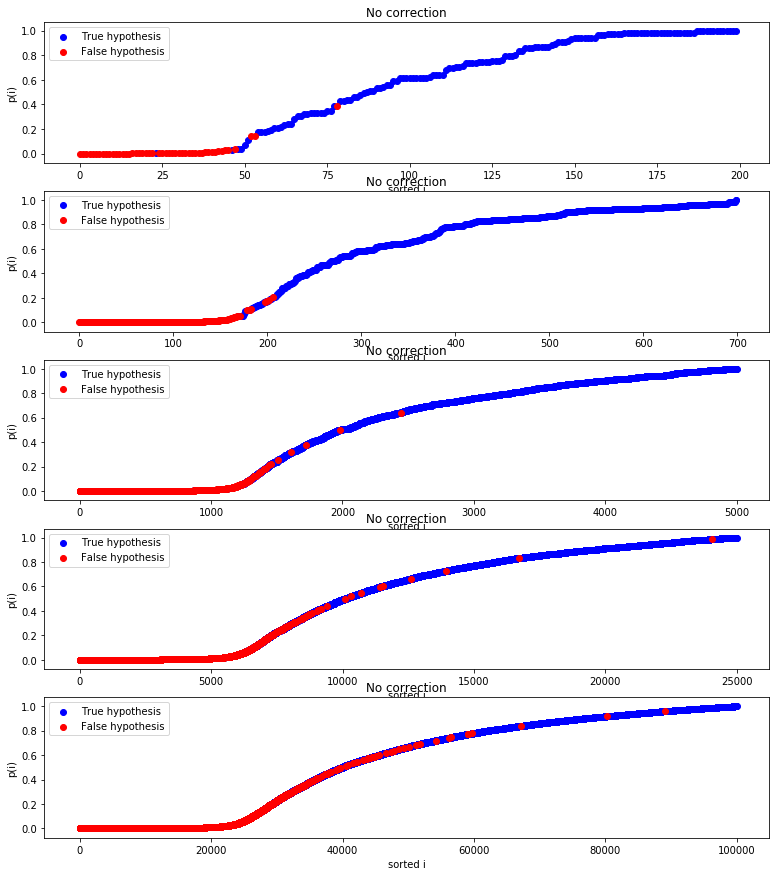

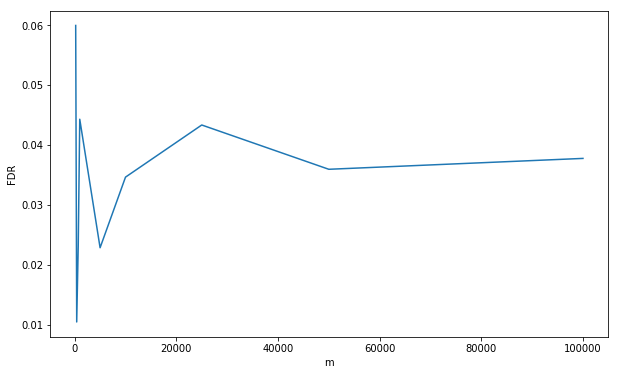

In [3]:
_ = plt.figure(figsize=(13, 15))

fdrs = []
for_graph = []
m_variants = [200, 400, 700, 1000, 5000, 10000, 25000, 50000, 100000]

for test_idx, m in enumerate(m_variants):
    m_0 = int(0.75 * m)
    X_0 = random_state.normal(0, 1, (m_0, n))
    X_1 = random_state.normal(1, 1, (m - m_0, n))
    X = np.concatenate([X_0, X_1])
    true, false, fdr = test(X, m_0)
    fdrs.append(fdr)
    if test_idx % 2 == 0:
        for_graph.append((true, false))
        print ("m: {0:6d}; FDR: {1:1.4f}".format(m, fdr))    

for idx, (true, false) in enumerate(for_graph):
    plt.subplot(len(for_graph), 1, idx + 1)
    plt.scatter(*zip(*true), label='True hypothesis', c='b')
    plt.scatter(*zip(*false), label='False hypothesis', c='r')
    plt.xlabel('sorted i')
    plt.ylabel('p(i)')
    plt.title('No correction')
    _ = plt.legend(loc='best')

plt.show()
plt.figure(figsize=(10, 6))
plt.plot(m_variants, fdrs)
plt.xlabel('m')
plt.ylabel('FDR')
plt.show()

### Выводы

Явной зависимости между **FDR** и $m$ не наблюдается.  
При малых $m$ **FDR** подвержена значительным колебаниям. Судя по всему, случайным.  
При больших ($\geq 10000$) эти колебания исчезают.

## Варьируем параметр $m_0$

* $m=2000$

* $m_0$ принимает значения от $0$ до $1800$

* $\alpha = 0.05$

m0:  0; FDR: 0.0000
m0: 260; FDR: 0.0052
m0: 521; FDR: 0.0136
m0: 782; FDR: 0.0269
m0: 1043; FDR: 0.0242
m0: 1304; FDR: 0.0250
m0: 1565; FDR: 0.0287


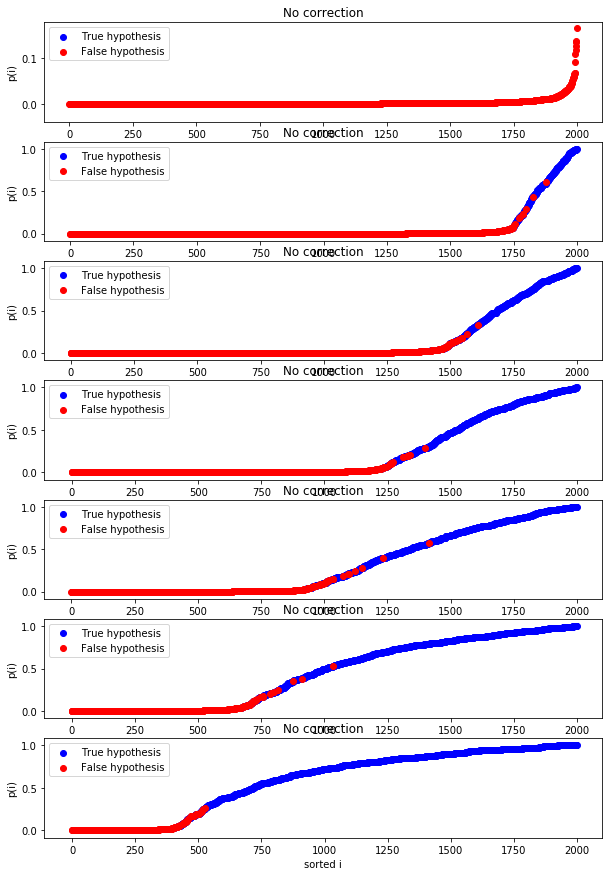

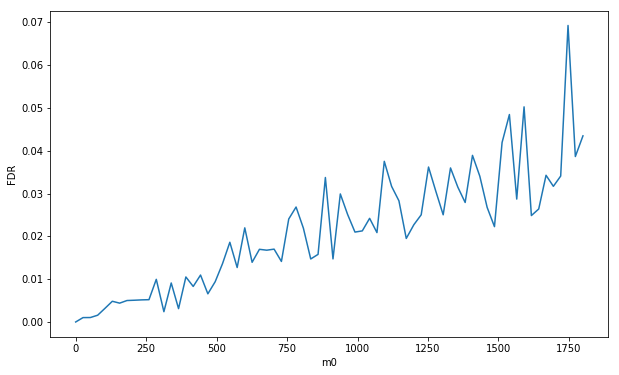

In [4]:
_ = plt.figure(figsize=(10, 15))

fdrs = []
for_graph = []
m = 2000
coeffs = np.linspace(0, 0.9, 70)
m0_variants = (m * coeffs).astype(int)

for test_idx, m_0 in enumerate(m0_variants):
    X_0 = random_state.normal(0, 1, (m_0, n))
    X_1 = random_state.normal(1, 1, (m - m_0, n))
    X = np.concatenate([X_0, X_1])
    true, false, fdr = test(X, m_0)
    fdrs.append(fdr)
    if test_idx % 10 == 0:
        for_graph.append((true, false))
        print ("m0: {0:2d}; FDR: {1:1.4f}".format(m_0, fdr))

for idx, (true, false) in enumerate(for_graph):
    plt.subplot(len(for_graph), 1, idx + 1)
    plt.scatter(*zip(*true), label='True hypothesis', c='b')
    plt.scatter(*zip(*false), label='False hypothesis', c='r')
    plt.xlabel('sorted i')
    plt.ylabel('p(i)')
    plt.title('No correction')
    _ = plt.legend(loc='best')
    
    
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(m0_variants, fdrs)
plt.xlabel('m0')
plt.ylabel('FDR')
plt.show()

### Вывод

**FDR** зависит от $m_0$. В среднем, зависимость близка к линейной.  
Отклонения **FDR** усиливаются с ростом $m_0$.

## Варьируем параметр $\alpha$

* $m=200$
* $m_0=150$ 
* $\alpha$ изменяется от $0.01$ до $0.25$

alpha: 0.016; FDR: 0.0077
alpha: 0.023; FDR: 0.0100
alpha: 0.035; FDR: 0.0155
alpha: 0.052; FDR: 0.0169
alpha: 0.078; FDR: 0.0221
alpha: 0.117; FDR: 0.0425
alpha: 0.174; FDR: 0.0652


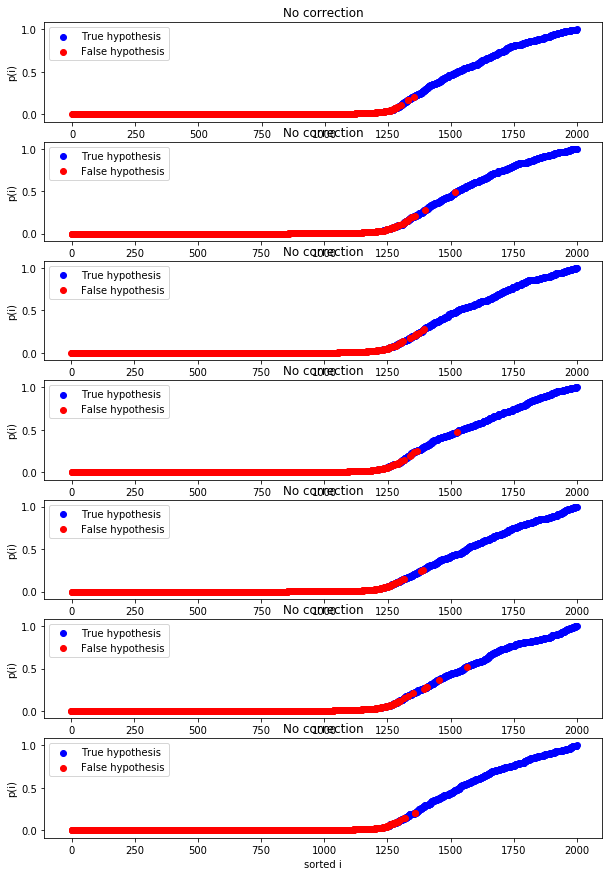

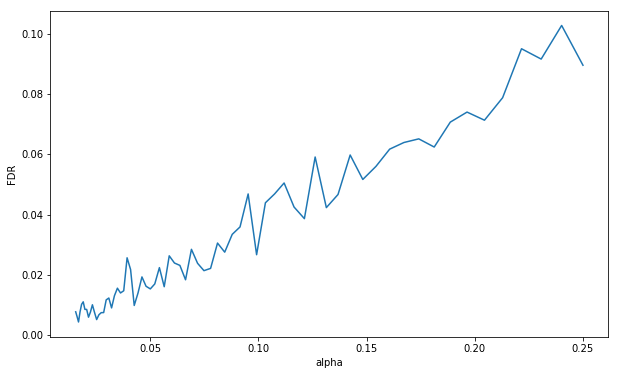

In [5]:
_ = plt.figure(figsize=(10, 15))

fdrs = []
for_graph = []
m = 2000
m_0 = 750
alpha_variants = np.logspace(-3, -1, 70, base=4)

for test_idx, alpha in enumerate(alpha_variants):
    X_0 = random_state.normal(0, 1, (m_0, n))
    X_1 = random_state.normal(1, 1, (m - m_0, n))
    X = np.concatenate([X_0, X_1])
    true, false, fdr = test(X, m_0, alpha)
    fdrs.append(fdr)
    if test_idx % 10 == 0:
        for_graph.append((true, false))
        print ("alpha: {0:.3f}; FDR: {1:1.4f}".format(alpha, fdr))

for idx, (true, false) in enumerate(for_graph):
    plt.subplot(len(for_graph), 1, idx + 1)
    plt.scatter(*zip(*true), label='True hypothesis', c='b')
    plt.scatter(*zip(*false), label='False hypothesis', c='r')
    plt.xlabel('sorted i')
    plt.ylabel('p(i)')
    plt.title('No correction')
    _ = plt.legend(loc='best')
    
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(alpha_variants, fdrs)
plt.xlabel('alpha')
plt.ylabel('FDR')
plt.show()

### Вывод

**FDR** растет при увеличении $\alpha$. Зависимость хорошо описывается линейной функцией.